In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
! pip install Wandb

In [ ]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint,WandbEvalCallback

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project = 'Emotion-Detection')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shubhamsagvekar438 (shubhamsagvekar438-reliance-retail). Use `wandb login --relogin` to force relogin


##**DATA MANAGEMENT**

##Data Downloading

In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

""" ~ = home directory , . = hidden , ! = shell command ,pip = python package installer , cp= copy , chmod = change mode, -d = directory where file should be extracted """

cp: cannot stat 'kaggle.json': No such file or directory


' ~ = home directory , . = hidden , ! = shell command ,pip = python package installer , cp= copy , chmod = change mode, -d = directory where file should be extracted '

In [4]:
! chmod 600 /root/.kaggle/kaggle.json
'''600: This sets the file's permissions so that only the owner of the file can read and write to it. No one else has any access to the file. Specifically:

6 = read (4) + write (2) permissions for the owner.
0 = no permissions for the group.
0 = no permissions for others.
'''

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


"600: This sets the file's permissions so that only the owner of the file can read and write to it. No one else has any access to the file. Specifically:\n\n6 = read (4) + write (2) permissions for the owner.\n0 = no permissions for the group.\n0 = no permissions for others.\n"

In [5]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes   #API command fron kaggle dataset
'''Website = https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes '''

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 309M/309M [00:04<00:00, 71.3MB/s]
100% 309M/309M [00:04<00:00, 75.1MB/s]


'Website = https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes '

In [6]:
! unzip /content/human-emotions-datasethes.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

##Making Directory

In [7]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ['angry','happy','sad']

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

##Dataset Loading

In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
    )

#inferred = creates class and object like train dataset has class as angry, happy, sad in subclass it has their images
#label_mode = take one hot encodeing creates vector for angry, happy sad [1 0 0],[0 1 0],[0 0 1]
#seed = for same shuffling


Found 6799 files belonging to 3 classes.


In [9]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
    )


Found 2278 files belonging to 3 classes.


In [10]:
for i in val_data.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

##Dataset Visualization

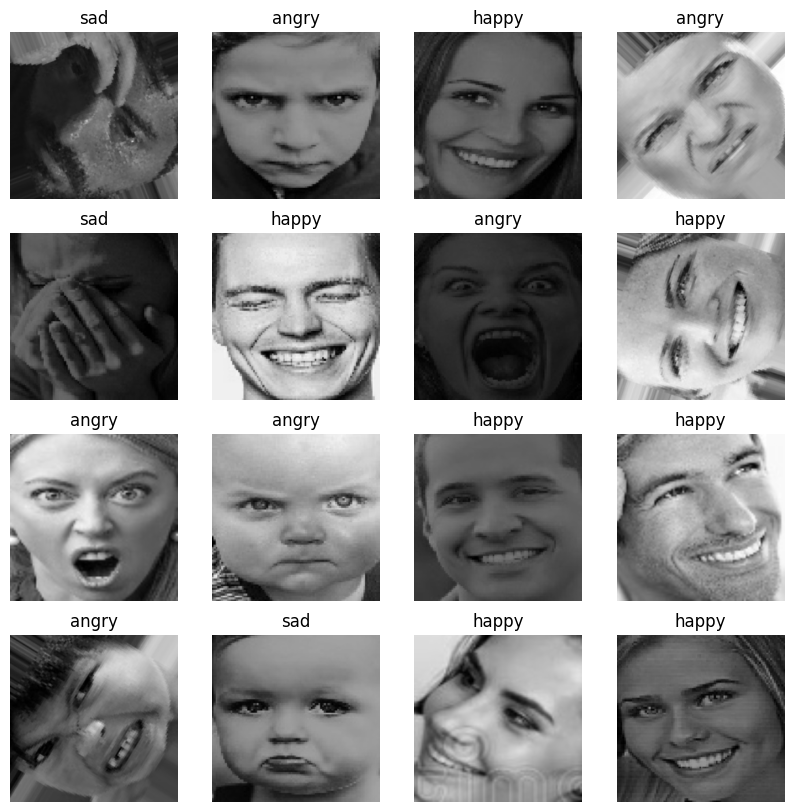

In [ ]:
plt.figure(figsize=(10,10))

for images ,labels in train_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis('off')

##Data Augmentation

In [11]:
###tf.keras.layer augment

augment_layers = tf.keras.Sequential([
                                     RandomRotation(factor = (-0.025,0.025)),
                                     RandomFlip(mode = 'horizontal'),
                                     RandomContrast(factor =0.1)
                                     ])

In [12]:
def augment_layer(image,label):
  return augment_layers(image,training = True),label

##Cutmix Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

##Dataset Preparation

In [ ]:
train_dataset_1 = train_data.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_data.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
#train_data = (
 #   mixed_dataset
   # .map(cutmix,num_parallel_calls = tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)
    #)

In [13]:
train_data = (
    train_data
    .map(augment_layer,num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
   )

In [14]:
val_data = (
    val_data
    .prefetch(tf.data.AUTOTUNE)
    )

In [15]:
resize_rescale_layers = tf.keras.Sequential([

                                            Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                            Rescaling(1./255)
])


#MODEL

##Lenet

In [16]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None,3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

##RESNET Model


In [ ]:
class CustomConv2D(Layer):
  def __init__(self,n_filters,kernel_size,n_strides ,padding='valid'):
    super(CustomConv2D,self).__init__(name = 'custom_conv_2D')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        strides = n_strides,
        padding = padding,
        activation = 'relu'
    )

    self.batch_norm = BatchNormalization()

  def call(self,x,training = True):

    x = self.conv(x)
    x = self.batch_norm(x,training=training)

    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self,n_channels,n_strides=1):
    super(ResidualBlock,self).__init__(name='residual_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels ,3 ,n_strides ,padding = 'same')
    self.custom_conv_2 = CustomConv2D(n_channels ,3 ,1 ,padding = 'same')

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels ,1 ,n_strides ,padding = 'same')

  def call(self,input, training =True):

    x = self.custom_conv_1(input ,training = training)
    x = self.custom_conv_2(x,training= training)

    if self.dotted:
      x_add = self.custom_conv_3(input,training= training)
      x_add = Add()([x,x_add])
    else:
      x_add = Add()([x,input])

    return self.activation(x_add)


In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34,self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64,7,2,padding='same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128,2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256,2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512,2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self,x,training = True):

    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training= training)
    x = self.conv_2_2(x, training= training)
    x = self.conv_2_3(x, training= training)

    x = self.conv_3_1(x, training= training)
    x = self.conv_3_2(x, training= training)
    x = self.conv_3_3(x, training= training)
    x = self.conv_3_4(x, training= training)

    x = self.conv_4_1(x, training= training)
    x = self.conv_4_2(x, training= training)
    x = self.conv_4_3(x, training= training)
    x = self.conv_4_4(x, training= training)
    x = self.conv_4_5(x, training= training)
    x = self.conv_4_6(x, training= training)

    x = self.conv_5_1(x, training= training)
    x = self.conv_5_2(x, training= training)
    x = self.conv_5_3(x, training= training)

    x = self.global_pool(x)

    return self.fc_3(x)


In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]))
resnet_34.summary()


Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv_2D (CustomConv2D)        │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 63, 63, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 512)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

##Efficient NET

In [17]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
backbone.trainable = False                 #freezing the weights because it should not update while training

In [19]:
model = tf.keras.Sequential([

                            Input(shape=((CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))),
                            backbone,
                            GlobalAveragePooling2D(),

                            Dense(CONFIGURATION['N_DENSE_1'],activation = 'relu'),
                            BatchNormalization(),

                            Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu'),
                            Dense(CONFIGURATION['NUM_CLASSES'],activation = 'softmax'),
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

##Fine-Tuned EfficientNet

In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape=((CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)))
x = backbone(input, training = False)

x = GlobalAveragePooling2D()(x)

x = Dense(CONFIGURATION['N_DENSE_1'],activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu')(x)

output = Dense(CONFIGURATION['NUM_CLASSES'],activation = 'softmax')(x)

finetuned_model = Model(input,output)

In [ ]:
finetuned_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

#CallBacks

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weight.keras',
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True
)

In [ ]:
wandb_callbacks = [
    WandbMetricsLogger(),  # Logs metrics to WandB
]

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in val_data:
      predicted.append(lenet_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in val_data.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)


    wandb.log({"Model Results" : val_table})

#Training

In [20]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name ="accuracy"),TopKCategoricalAccuracy(k=2,name = "top_k_accuracy")]

In [ ]:
'''# Change the loss function to SparseCategoricalCrossentropy
loss_function = SparseCategoricalCrossentropy()
# Use SparseCategoricalAccuracy for metrics
metrics = [SparseCategoricalAccuracy(name ="accuracy")]'''

In [21]:
model.compile(
    optimizer = Adam(CONFIGURATION['LEARNING_RATE']/100),
    loss = loss_function,
    metrics = metrics
)

In [22]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 5,#CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    #callbacks = [wandb_callbacks,LogConfMatrix(),LogResultsTable()]
)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 201s 645ms/step - accuracy: 0.4652 - loss: 1.1686 - top_k_accuracy: 0.7685 - val_accuracy: 0.6185 - val_loss: 0.8620 - val_top_k_accuracy: 0.8626
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 117s 414ms/step - accuracy: 0.6472 - loss: 0.8142 - top_k_accuracy: 0.8797 - val_accuracy: 0.6844 - val_loss: 0.7314 - val_top_k_accuracy: 0.8867
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 137s 393ms/step - accuracy: 0.6976 - loss: 0.7085 - top_k_accuracy: 0.9058 - val_accuracy: 0.7050 - val_loss: 0.6935 - val_top_k_accuracy: 0.8973
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 143s 397ms/step - accuracy: 0.7200 - loss: 0.6577 - top_k_accuracy: 0.9099 - val_accuracy: 0.7239 - val_loss: 0.6556 - val_top_k_accuracy: 0.9047
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 85s 399ms/step - accuracy: 0.7379 - loss: 0.6247 - top_k_accuracy: 0.9200 - val_accuracy: 0.7344 - val_loss: 0.6335 - val_top_k_accuracy: 0.9100


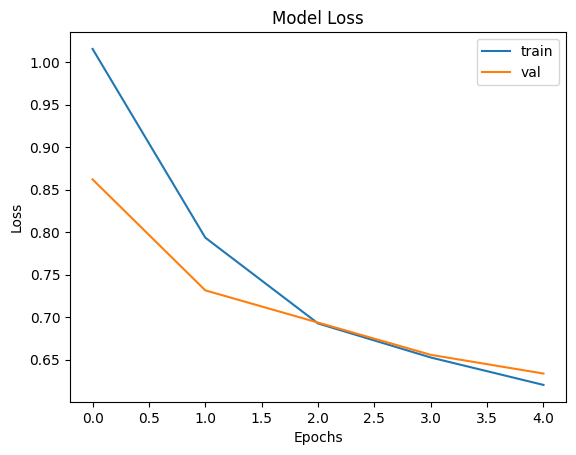

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

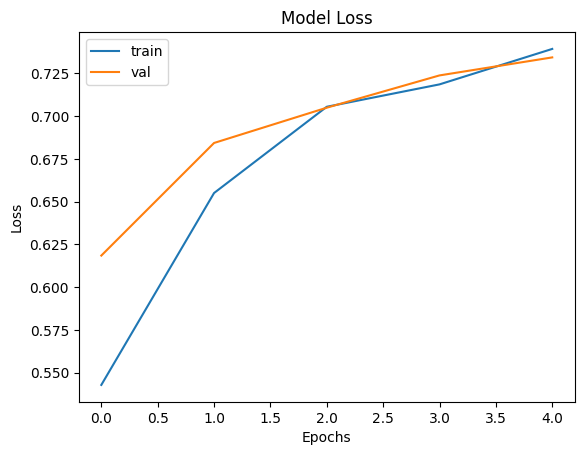

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

In [25]:
model.save("/content/pretrained_model1.h5")

#Evaluation


In [ ]:
lenet_model.evaluate(val_data)

72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 759ms/step - accuracy: 0.6770 - loss: 0.7876 - top_k_accuracy: 0.8817


[0.7901681065559387, 0.6729587316513062, 0.874012291431427]

#Testing

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")

im = tf.constant(test_image ,dtype =tf.float32)

im = tf.expand_dims(im ,axis =0)

print(CLASS_NAMES[tf.argmax(lenet_model(im),axis =-1).numpy()[0]])

happy


InvalidArgumentError: {{function_node __wrapped__ArgMax_device_/job:localhost/replica:0/task:0/device:GPU:0}} Expected dimension in the range [0, 0), but got 0 [Op:ArgMax] name: 

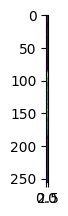

In [ ]:
plt.figure(figsize=(10,10))

for images ,labels in val_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title("True Label : " + CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label : " + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i],axis=0)),axis =-1).numpy()[0]])
    plt.axis('off')
    plt.tight_layout()

#Confusion Matrix

In [ ]:
predicted = []
labels = []

for im,label in val_data:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()]))

[1 0 2 ... 0 1 0]
[1 0 2 ... 0 1 0]


In [ ]:
Actual = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
Predicted =np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[405  61  49]
 [101 805 100]
 [145 107 505]]


Text(95.72222222222221, 0.5, 'True Label')

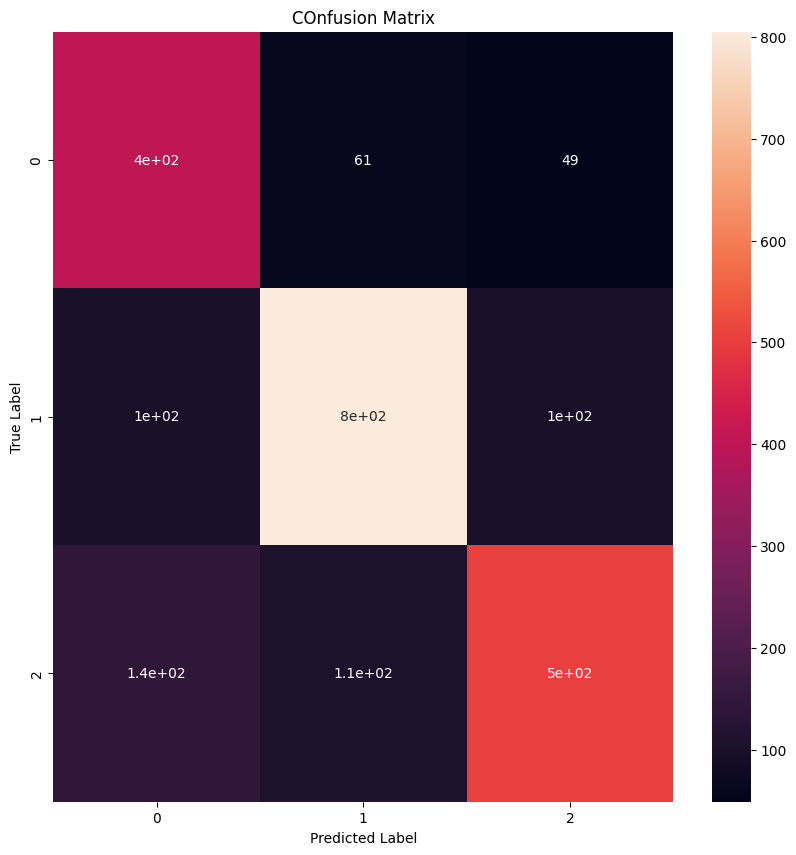

In [ ]:
cm = confusion_matrix(Actual ,Predicted)
print(cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True)
plt.title("COnfusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#TF_Records

In [ ]:
#unbatching
train_data = (
    train_data
    .unbatch()
)

In [ ]:
val_data = (
    val_data
    .unbatch()
)

In [ ]:
#Creating example for process
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,

      }))
  return example.SerializeToString()

#Note - int feature for label and byte feature for images

In [ ]:
NUM_SHARDS = 10          #slices for dataset
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
#changing dtype from float to uint8 and changing tensor image to  bytes
def encode_image(image,label):
  image = tf.image.convert_image_dtype(image, dtype= tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image, tf.argmax(label)

In [ ]:
encoded_dataset = (
    train_data
    .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):                           #iterate for each slice

 sharded_dataset = (                                             #slices created for encoded dataset using shard method
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)
        .as_numpy_iterator()
    )

 with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:              #creating file and writing into it
    for image,label in sharded_dataset:
      file_writer.write(create_example(image, label))

In [ ]:
recons_dataset = tf.data.TFRecordDataset(filenames = [PATH.format(i) for i in range(NUM_SHARDS)])  #collecting all 10 slices together into lists

In [ ]:
#again converting bytes to tensor
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.io.decode_jpeg(example["images"], channels = 3)

    return example["images"], example["labels"]

In [ ]:
#dataset
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

#Feature Map (VGG16) || Inside hidden layer

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)
)

In [ ]:
vgg_backbone.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_map = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_map
)

feature_map_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

im = tf.constant(test_image ,dtype =tf.float32)
im = tf.expand_dims(im ,axis =0)

f_maps = feature_map_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
len(f_maps)

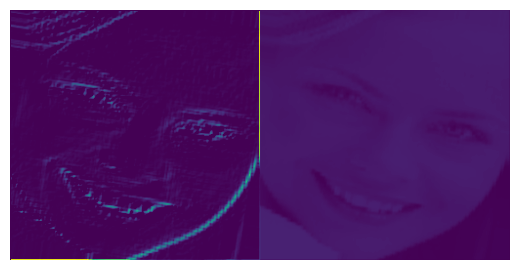

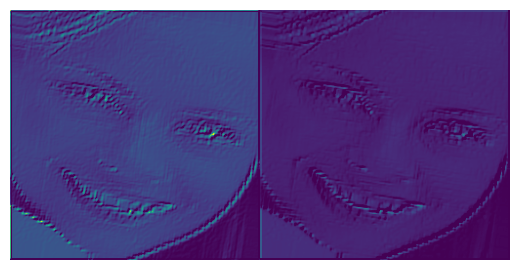

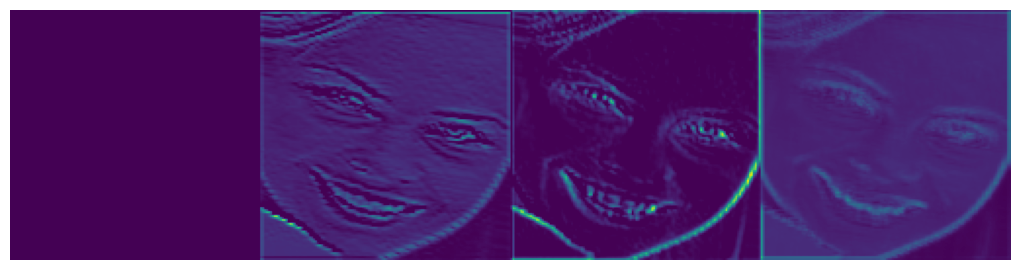

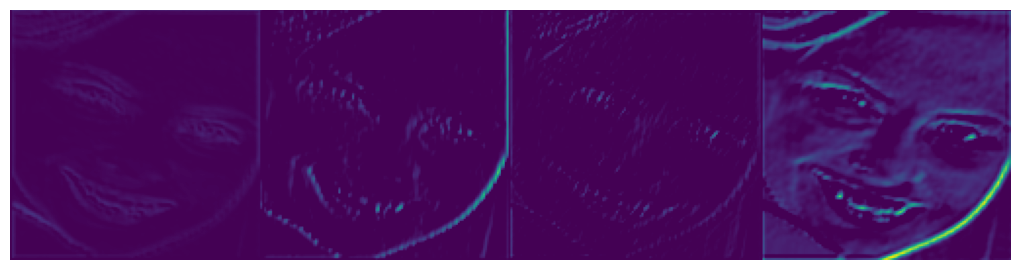

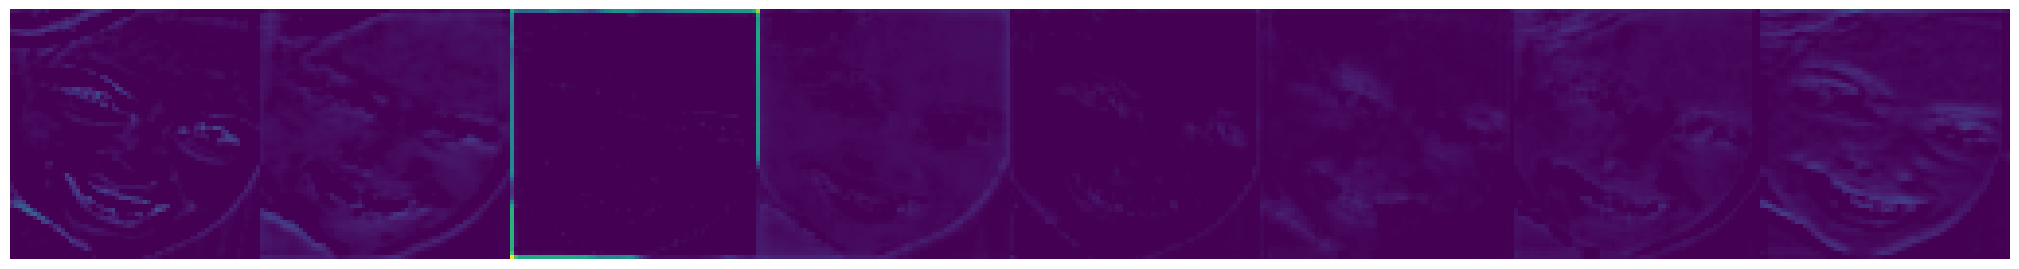

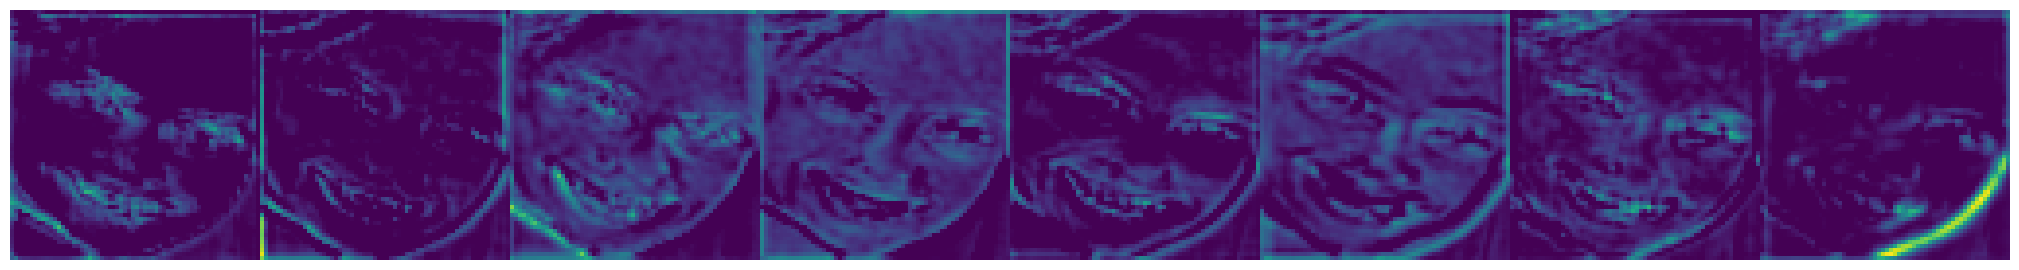

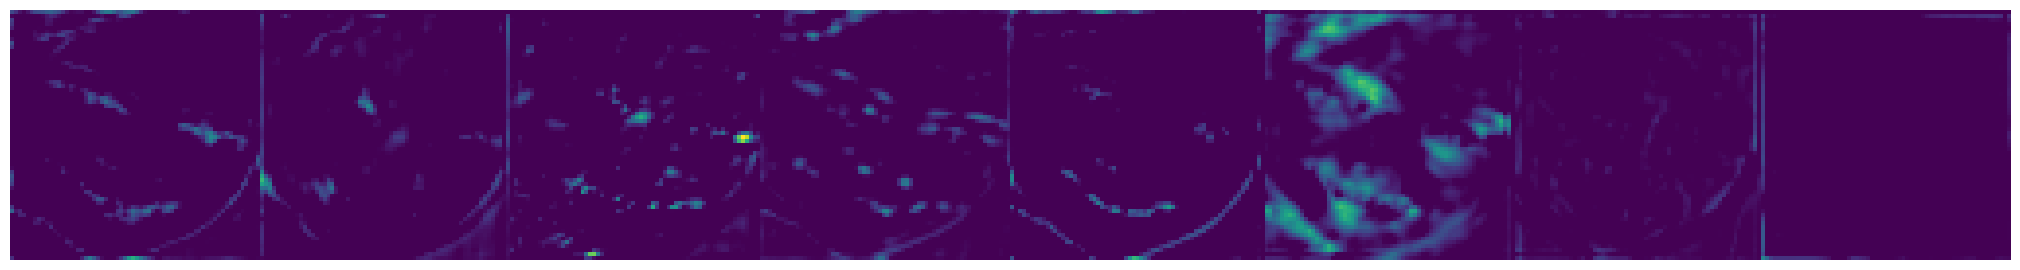

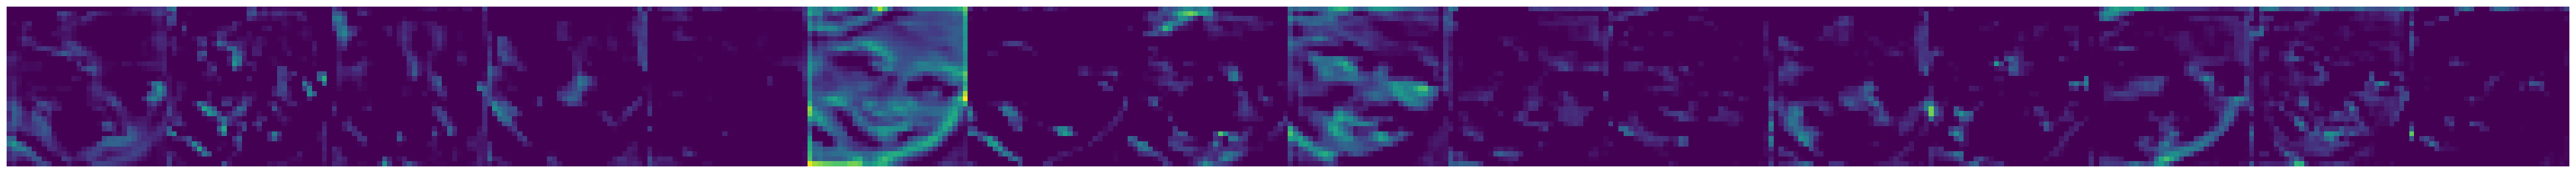

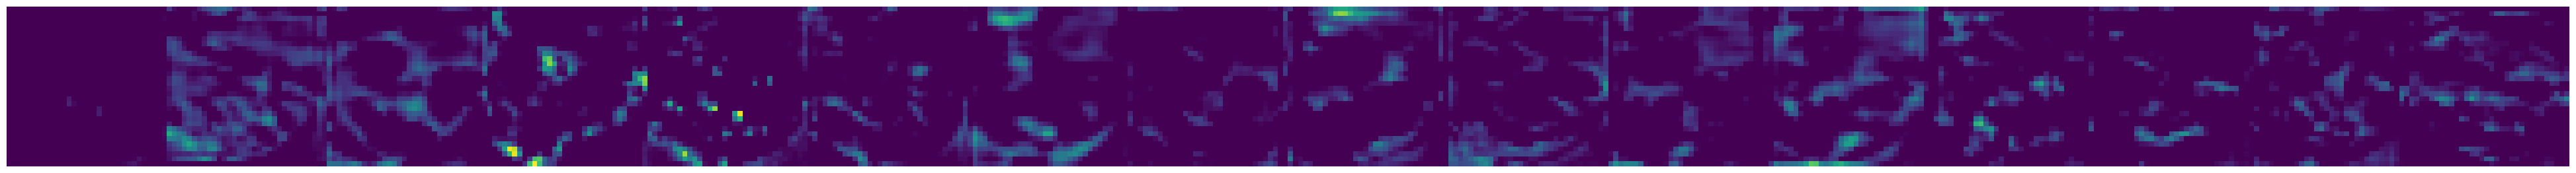

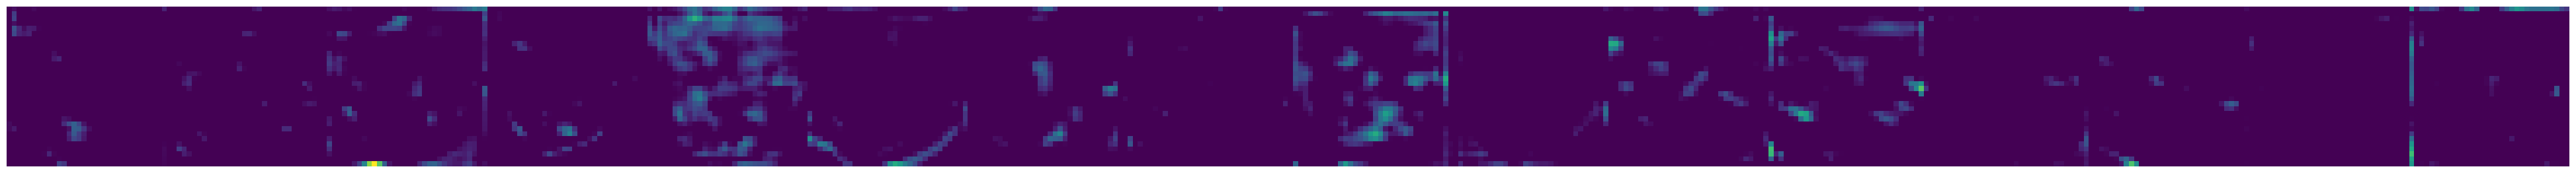

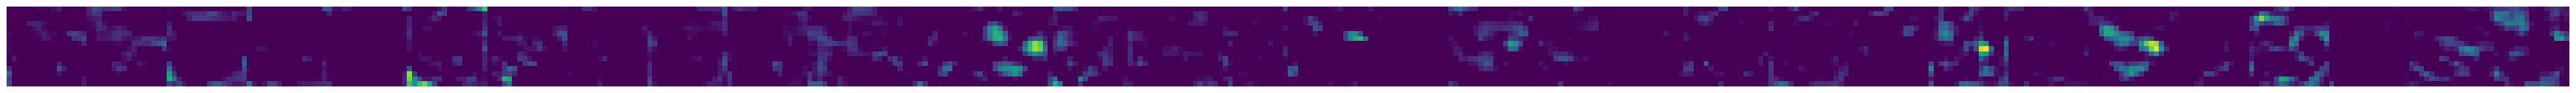

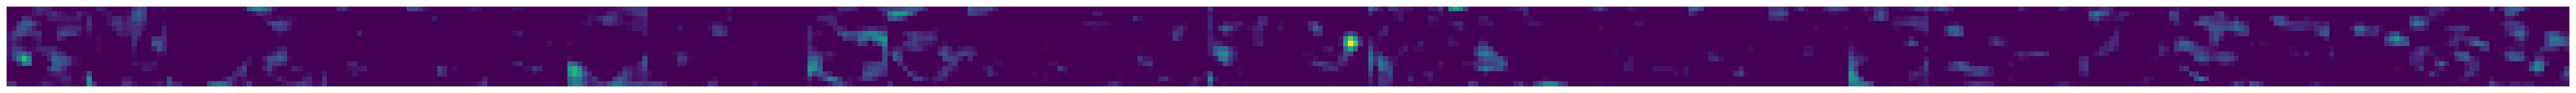

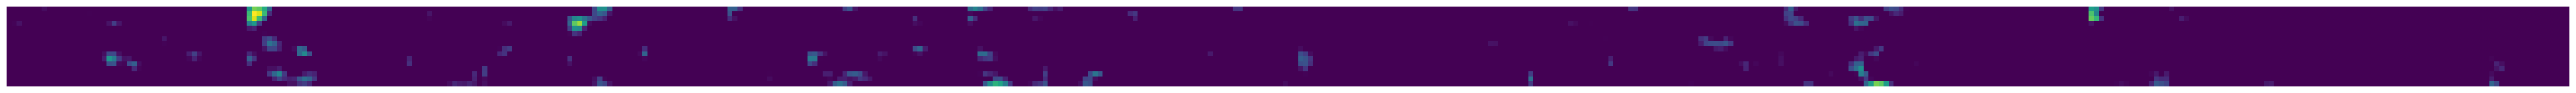

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize=(50,50))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.zeros((f_size , f_size*n_channels))     #creating blank canvas

  ax = plt.subplot(len(f_maps),1,i+1)

  for j in range(n_channels):
    joint_maps[: ,f_size*j : f_size*(j+1)] = f_maps[i][... ,j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis('off')

#Vision Transformer

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101810.jpg_rotation_1.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image,axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
print(patches.shape)

(1, 16, 16, 768)


In [ ]:
patches = tf.reshape(patches,(patches.shape[0],256,768))
print(patches.shape)

(1, 256, 768)


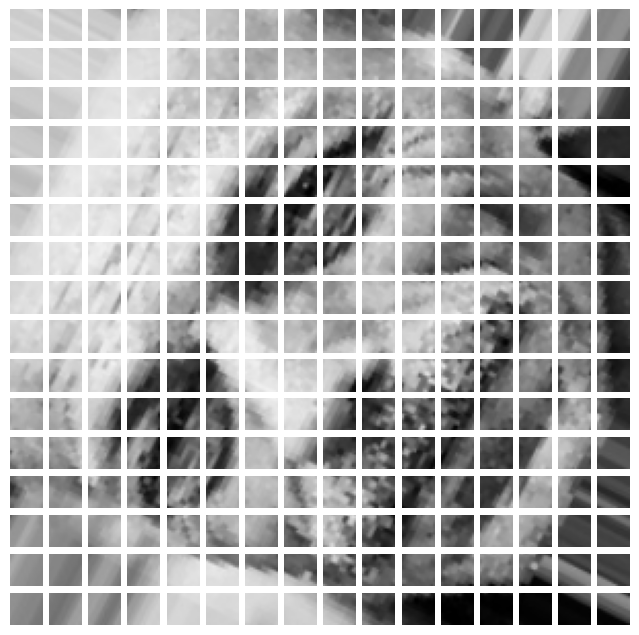

In [ ]:
plt.figure(figsize=(8,8))
for i in range(patches.shape[1]):
  ax = plt.subplot(16,16,i+1)
  plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
  plt.axis('off')


In [ ]:
#Patch making and , linear projection and position embeddings
class PatchEncoder(Layer):
  def __init__(self,N_PATCH_SIZE,HIDDEN_SIZE):
    super(PatchEncoder,self).__init__(name = 'patch_encoder')

    self.liner_projection =  Dense(HIDDEN_SIZE)
    self.positional_enbeddings = Embedding(N_PATCH_SIZE,HIDDEN_SIZE)     #N_PATCH_SIZE = 256 , HIDDEN_SIZE = 768
    self.N_PATCHES = N_PATCH_SIZE

  def call(self,x):
    patches = tf.image.extract_patches(
                           images=x,
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

    patches = tf.reshape(patches,(tf.shape(patches)[0],256,patches.shape[-1]))
    embedding_input = tf.range(start = 0 ,limit = self.N_PATCHES , delta = 1)
    output = self.liner_projection(patches) + self.positional_enbeddings(embedding_input)

    return output

In [ ]:
'''model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(256,768))
input_array = np.random.randint(256, size=(1, 256))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)'''

"model = tf.keras.Sequential()\nmodel.add(tf.keras.layers.Embedding(256,768))\ninput_array = np.random.randint(256, size=(1, 256))\nmodel.compile('rmsprop', 'mse')\noutput_array = model.predict(input_array)\nprint(output_array.shape)"

In [ ]:
patch_enc = PatchEncoder(256,768)
patch_enc(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 3.3933077e-02,  1.3740208e-02,  3.7481073e-02, ...,
          3.6827873e-02,  2.0556454e-02, -3.7729491e-02],
        [ 1.4782000e-02,  3.8614396e-02,  3.3763614e-02, ...,
          7.5083971e-03,  3.4286287e-02, -2.8798152e-02],
        [-4.0159844e-02,  2.3812000e-02, -2.1588326e-02, ...,
          2.7694080e-02,  2.7374361e-02,  5.9222467e-03],
        ...,
        [ 2.1111343e-02, -2.8147591e-02, -4.2549588e-02, ...,
         -1.5135694e-02,  7.3800907e-03, -2.4987889e-02],
        [-1.5779734e-03,  1.8396702e-02,  3.9372053e-02, ...,
          9.2506409e-05,  4.8121065e-04,  3.3224974e-02],
        [-6.0021169e-03,  2.6599970e-02,  4.5146320e-02, ...,
         -2.7956814e-04, -2.2186434e-02, -1.3818853e-03]]], dtype=float32)>

In [ ]:
#transformer encoding
class TransformerEncoder(Layer):
  def __init__(self,N_HEADS,HIDDEN_SIZE):
    super(TransformerEncoder,self).__init__(name = 'transfer_encoder')

    self.layer_norm_1 =  LayerNormalization()
    self.layer_norm_2 =  LayerNormalization()

    self.multihead_att = MultiHeadAttention(N_HEADS,HIDDEN_SIZE)    #N_PATCH_SIZE = 256 , HIDDEN_SIZE = 768

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self,input):
    x1 = self.layer_norm_1(input)
    x1 = self.multihead_att(x1,x1)

    x1 = Add()([x1,input])

    x2 = self.layer_norm_2(x1)
    x2 = self.dense_1(x2)
    x2 = self.dense_2(x2)

    output = Add()([x2,x1])


    return output

In [ ]:
trans_enc = TransformerEncoder(8,768)
trans_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
#ViT Model
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')

    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(N_PATCHES=256, N_HEADS=2,HIDDEN_SIZE=768,N_LAYERS=2,N_DENSE_UNITS=128)
vit(tf.zeros([32,256,256,3]))


<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.3261486, 0.2861585],
       [0.3876929, 0.326148

In [ ]:
vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)         │ ?                           │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transfer_encoder                     │ ?                           │       5,908,224 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transfer_encoder                     │ ?                           │       5,908,224 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (32, 128)                   │      25,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (32, 3)                     │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,786,499 (144.14 MB)

 Trainable params: 37,786,499 (144.14 MB)

 Non-trainable params: 0 (0.00 B)

#Hugging Face

##Installation

In [ ]:
! pip install transformers

In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

##Training

In [ ]:

resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))
])

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
#print(x)
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


ValueError: Exception encountered when calling layer 'vit' (type TFViTMainLayer).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'vit' (type TFViTMainLayer):
  • pixel_values=<KerasTensor shape=(None, 3, 224, 224), dtype=float32, sparse=False, name=keras_tensor_5>
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [ ]:
hf_model(tf.expand_dims(test_image, axis = 0))

hf_model.summary()

NameError: name 'hf_model' is not defined

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name ="accuracy"),TopKCategoricalAccuracy(k=2,name = "top_k_accuracy")]

hf_model.compile(
    optimizer = Adam(CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = hf_model.fit(
    train_data,
    validation_data = val_data,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    #callbacks = [checkpoint_callback]
)

#ONNX Format

In [17]:
lenet_model.export("lenet_base")

Saved artifact at 'lenet_base'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138838005008512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005010976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005010448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005015376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005014320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005009216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005011680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005019776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005016960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005020304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138838005013968:

In [18]:
lenet_model.save("lenet_base.h5")

##Installation

In [24]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


##From Keras Model

In [25]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

input_tensor = tf.keras.Input(shape=(256, 256, 3))
output_tensor = lenet_model(input_tensor) # Assuming 'lenet_model' is your Sequential model

output_tensor = tf.keras.layers.Dense(units=3, name="dense_2")(output_tensor) # Changed Layer to Dense and added units
functional_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)


model_proto, _ = tf2onnx.convert.from_keras(functional_model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [26]:
print(output_names)

['dense_2']


##Conversion

In [27]:
! python -m tf2onnx.convert --saved-model lenet_base --output lenet_onnx.onnx

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
I0000 00:00:1727931627.292081    2162 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727931627.672146    2162 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727931627.672525    2162 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA n

##Inference

In [28]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]))

im = test_image.astype(np.float32)
im = np.expand_dims(im,axis=0)

In [29]:
N_PREDICTION = 10

In [30]:
providers = ['CPUExecutionProvider']

m=rt.InferenceSession("/content/lenet_keras.onnx",providers=providers)
t1 = time.time()
for _ in range(N_PREDICTION):
  onnx_pred = m.run(output_names,{"input":im})

  predicted_class = np.argmax(onnx_pred,axis=-1).flatten()

print(CONFIGURATION["CLASS_NAMES"][predicted_class[0]])
print('Time for single prediction : ',(time.time()-t1)/N_PREDICTION)

happy
Time for single prediction :  0.04693560600280762


In [31]:
rt.get_device()

'GPU'

#Quantization

In [32]:
import onnx
from onnxruntime.quantization import quantize_dynamic ,QuantType

In [33]:
model_fp32 = '/content/lenet_keras.onnx'
model_quant = '/content/lenet_quant.onnx'

quantized_model = quantize_dynamic(model_fp32,model_quant,weight_type=QuantType.QUInt8)

In [34]:
providers = ['CPUExecutionProvider']

m=rt.InferenceSession("/content/lenet_quant.onnx",providers=providers)
t1 = time.time()
for _ in range(N_PREDICTION):
  onnx_pred = m.run(output_names,{"input":im})

  predicted_class = np.argmax(onnx_pred,axis=-1).flatten()

print(CONFIGURATION["CLASS_NAMES"][predicted_class[0]])
print('Time for single prediction : ',(time.time()-t1)/N_PREDICTION)

happy
Time for single prediction :  0.010938811302185058


##Accuracy Drop due to Quantization

In [35]:

def accuracy(model):
  total, acc = 0,0
  for im, label in val_data:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [36]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/lenet_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/lenet_quant.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

0.4305555555555556
0.4305555555555556


##Quantization Aware Training

In [37]:
!pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.1 MB/s eta 0:00:00


In [38]:
import tensorflow_model_optimization as tfmot

In [39]:
#EfficientNet Functional Model
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

In [ ]:
#quant_aware_model = tfmot.quantization.keras.quantize_model(pretrained_func_model)

In [64]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [65]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model, clone_function=apply_quantization_to_conv
)

ValueError: `to_annotate` can only be a `keras.layers.Layer` instance. You passed an instance of type: ZeroPadding2D.

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

#PTQ(Post Training Quantization)
Conversion to TensorFlow Lite


In [26]:
model.load_weights("/content/pretrained_model1.h5")

In [27]:
model.evaluate(val_data)

72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.7198 - loss: 0.6663 - top_k_accuracy: 0.9022


[0.6335163116455078, 0.734416127204895, 0.9100087881088257]

In [28]:
def representative_data_gen():
  for input_value, j in val_data.take(20):
    yield [input_value]

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen


In [31]:
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpsm3oexw6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_498')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138093403628720: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138093403631008: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138093403633472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093401737696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093401735584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093403633824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093401736112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093401740160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093401740688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138093401744384: TensorSpec(shape=(), dtype=tf.resource, name=

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [32]:
import pathlib

tflite_model_dir = pathlib.Path("/content/quantized_model")
tflite_model_dir.mkdir(exist_ok = True ,parents = True)

tflite_model_file = tflite_model_dir/"quantized_model.tflite"
tflite_model_file.write_bytes(tflite_model)


22149112

##Tflite runtime

In [33]:
!pip3 install --extra-index-url https://https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://https://google-coral.github.io/py-repo/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.3 MB/s eta 0:00:00


In [38]:
import tflite_runtime.interpreter as tflite
import numpy as np
import cv2

In [45]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/112938.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
test_image = np.expand_dims(test_image, axis = 0)

In [47]:
interpreter = tflite.Interpreter(model_path="/content/quantized_model/quantized_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
# test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]

In [48]:
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])

sad


##Accuracy of Tflite

In [49]:
def accuracy(model_path):
  total,correct = 0,0

  interpreter = tflite.Interpreter("model_path=model_path")
  interpreter.allocate_tensors()

  input_detials = interpreter.get_input_detials()[0]
  output_details = interpreter.get_output_detials()[0]

  for im,label in val_data:
    test_image = im.numpy().as_type(input_details["dtype"])

  interpreter.set_tensor(input_details["index"],test_image)
  interpreter.invoke()

  output = interpreter.get_tensor(output_detials["index",])[0]

  if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
    correct += 1

  total += 1
  return correct/total

{'name': 'serving_default_keras_tensor_498:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([ -1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
